<a href="https://colab.research.google.com/github/AhmedMaherAbdRabbo/GTC-Land-Type-Classification/blob/main/GTC_Land_Type_Classification_EDA_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("eurosat/rgb", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.H58OCO_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [2]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names
total_samples = info.splits['train'].num_examples

print(f"Total samples: {total_samples}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Total samples: 27000
Number of classes: 10
Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [3]:
train_size = 0.8
train_data = dataset['train'].take(int(total_samples * train_size))
val_data = dataset['train'].skip(int(total_samples * train_size))

In [4]:
import tensorflow as tf

IMG_SIZE = 64

def preprocess(image, label, augment=False):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0

    if augment:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, label

In [5]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_loader = (
    train_data
    .map(lambda x, y: preprocess(x, y, augment=True), num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_loader = (
    val_data
    .map(lambda x, y: preprocess(x, y, augment=False), num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

###📊 Exploratory Data Analysis (EDA) & Feature Engineering
In this section, we :

 • ✔ Explore the EuroSAT dataset distribution and balance between classes.

 • ✔ Visualize random samples of satellite images for each land cover type.

 • ✔ Analyze pixel intensity distributions to understand color patterns.

 • ✔ Compare original vs augmented images to verify preprocessing.

 • ✔ Compute dataset statistics (mean, std) that can be used for normalization.

 • ✔ Plot Pie Charts to visualize class balance in a more intuitive way.

 • ✔ Perform Variability Analysis within classes to understand internal diversity.

 • ✔ Build a Heatmap of Class Similarities based on mean RGB values across land cover types.

This structured analysis helps us better understand the data before training, identify possible challenges (e.g., class imbalance), and improve model robustness using feature engineering.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import collections
import tensorflow as tf
import seaborn as sns
import collections
import random

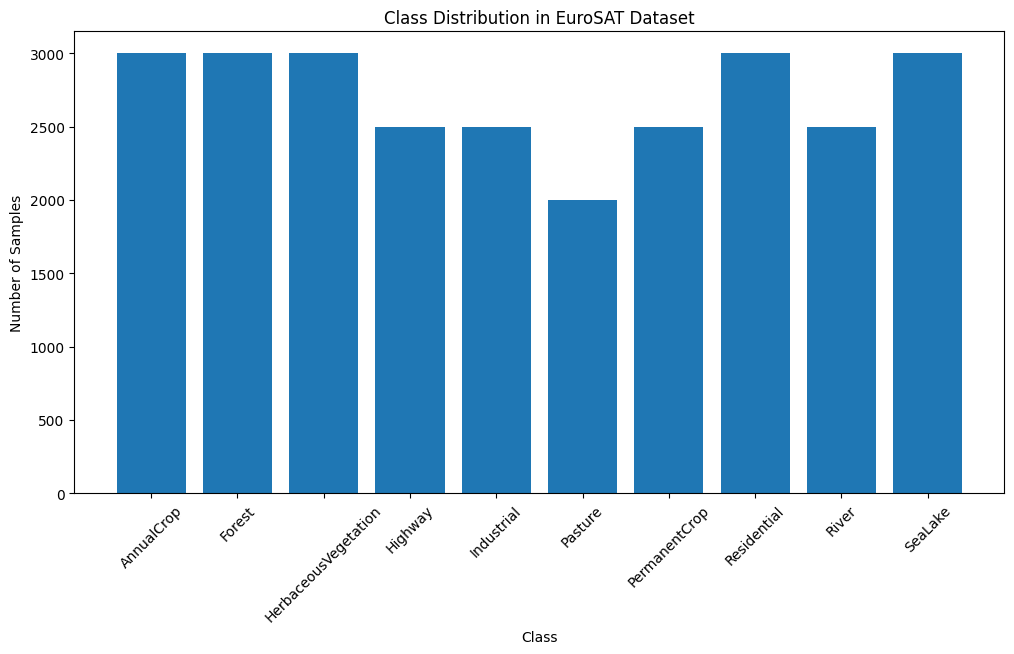

In [7]:
label_counts = collections.Counter()
for _, label in dataset['train']:
    label_counts[int(label.numpy())] += 1

plt.figure(figsize=(12, 6))
plt.bar(range(num_classes), [label_counts[i] for i in range(num_classes)])
plt.xticks(range(num_classes), class_names, rotation=45)
plt.title("Class Distribution in EuroSAT Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

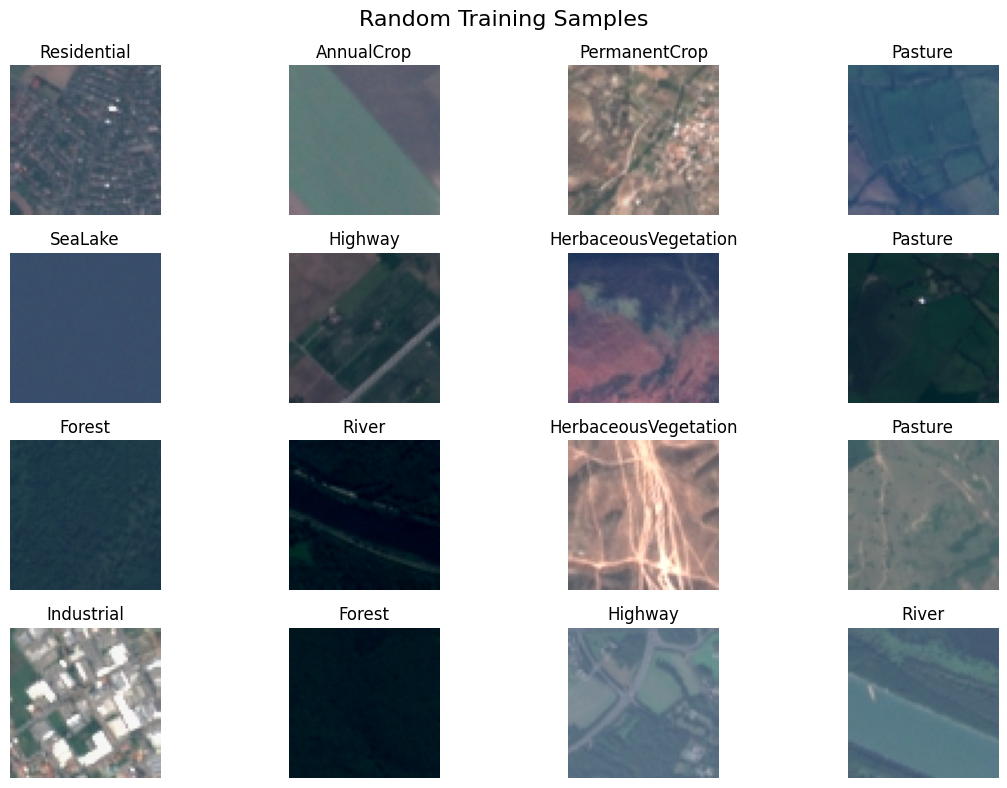

In [8]:
for images, labels in train_loader.take(1):
    plt.figure(figsize=(12, 8))
    for i in range(min(16, images.shape[0])):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.suptitle("Random Training Samples", fontsize=16)
    plt.tight_layout()
    plt.show()
    break

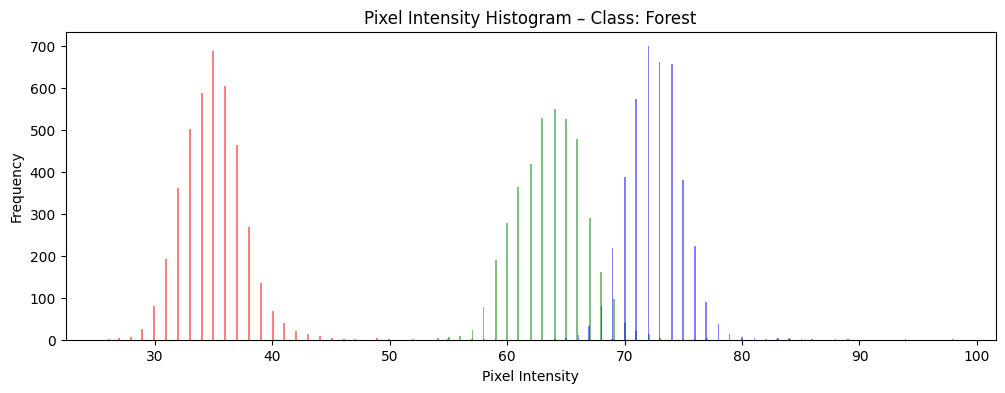

In [9]:
raw_train = dataset['train'].take(1)
for image, label in raw_train:
    plt.figure(figsize=(12, 4))
    colors = ['r', 'g', 'b']
    for i, color in enumerate(colors):
        plt.hist(image.numpy()[:, :, i].ravel(), bins=256, color=color, alpha=0.5)
    plt.title(f"Pixel Intensity Histogram – Class: {class_names[label.numpy()]}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()
    break


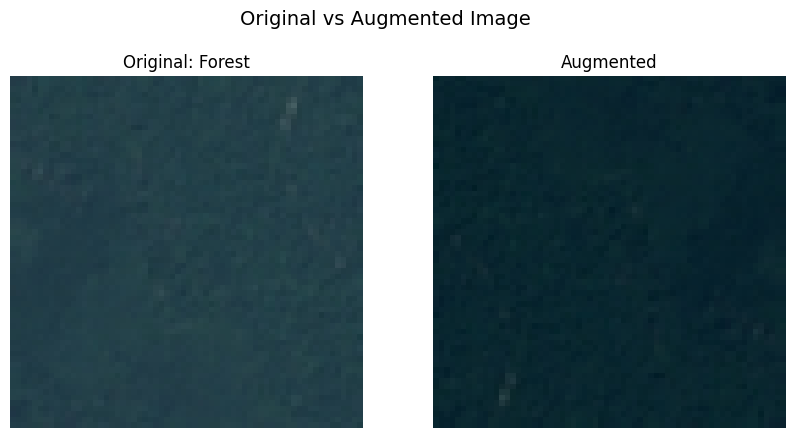

In [10]:
for image, label in dataset['train'].take(1):
    plt.figure(figsize=(10, 5))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy())
    plt.title(f"Original: {class_names[label.numpy()]}")
    plt.axis("off")

    # Augmented
    aug_img, _ = preprocess(image, label, augment=True)
    plt.subplot(1, 2, 2)
    plt.imshow(aug_img.numpy())
    plt.title("Augmented")
    plt.axis("off")

    plt.suptitle("Original vs Augmented Image", fontsize=14)
    plt.show()
    break

In [11]:
channel_sum = np.zeros(3)
channel_sum_sq = np.zeros(3)
num_samples = 0

for img, _ in dataset['train'].take(2000):
    img = tf.cast(img, tf.float32) / 255.0
    img_np = img.numpy()
    channel_sum += img_np.mean(axis=(0, 1))
    channel_sum_sq += (img_np ** 2).mean(axis=(0, 1))
    num_samples += 1

mean = channel_sum / num_samples
std = np.sqrt(channel_sum_sq / num_samples - mean ** 2)

print("Channel Means (R,G,B):", mean)
print("Channel Stds (R,G,B):", std)

Channel Means (R,G,B): [0.34675499 0.38444264 0.40615458]
Channel Stds (R,G,B): [0.20865788 0.1413617  0.11896122]


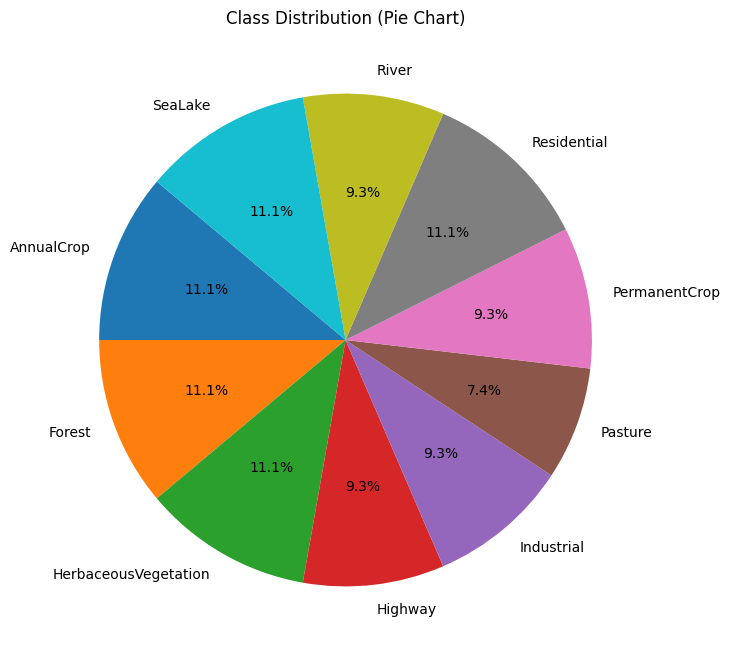

In [12]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names


label_counts = collections.Counter()
for _, label in dataset['train']:
    label_counts[int(label.numpy())] += 1

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    [label_counts[i] for i in range(num_classes)],
    labels=class_names,
    autopct='%1.1f%%',
    startangle=140
)
plt.title("Class Distribution (Pie Chart)")
plt.show()



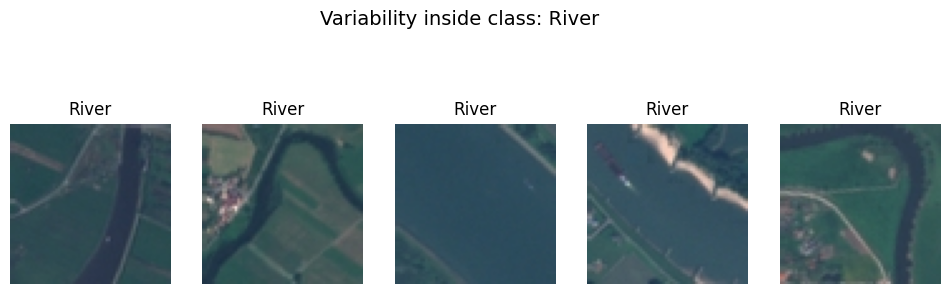

In [13]:
target_class = "River"
target_class_idx = class_names.index(target_class)


images_of_class = []
for img, label in dataset['train']:
    if label.numpy() == target_class_idx:
        images_of_class.append(img)
    if len(images_of_class) >= 5:
        break

plt.figure(figsize=(12, 4))
for i, img in enumerate(images_of_class):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img.numpy())
    plt.title(target_class)
    plt.axis("off")
plt.suptitle(f"Variability inside class: {target_class}", fontsize=14)
plt.show()

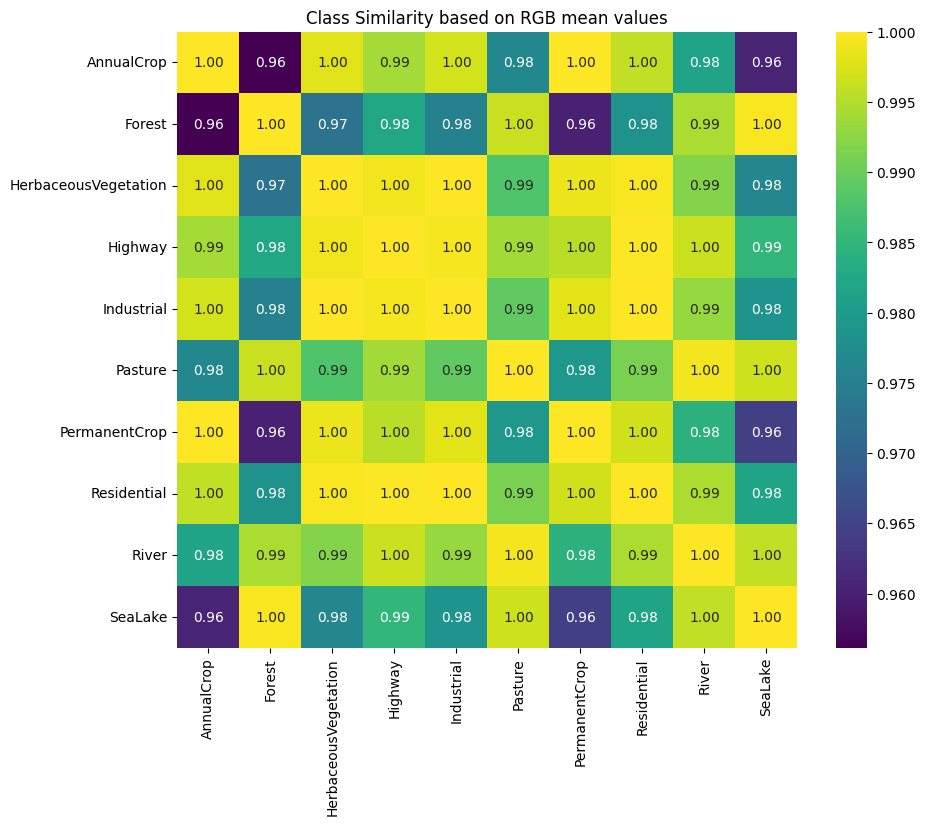

In [14]:
num_classes = info.features['label'].num_classes
class_names = info.features['label'].names


class_means = np.zeros((num_classes, 3))
counts = np.zeros(num_classes)

for img, label in dataset['train']:
    idx = label.numpy()
    img = img.numpy().astype("float32") / 255.0
    class_means[idx] += img.mean(axis=(0,1))
    counts[idx] += 1


for i in range(num_classes):
    class_means[i] /= counts[i]


from numpy.linalg import norm

similarity = np.zeros((num_classes, num_classes))
for i in range(num_classes):
    for j in range(num_classes):
        dot = np.dot(class_means[i], class_means[j])
        similarity[i, j] = dot / (norm(class_means[i]) * norm(class_means[j]))


plt.figure(figsize=(10,8))
sns.heatmap(similarity, xticklabels=class_names, yticklabels=class_names, annot=True, cmap="viridis", fmt=".2f")
plt.title("Class Similarity based on RGB mean values")
plt.show()

###✅ Summary of Phase 2 Work
 • We successfully performed Exploratory Data Analysis (EDA): visualized class distribution, inspected random samples, analyzed pixel intensity patterns, and explored dataset balance.

 • We applied Feature Engineering:

 • Normalization using computed channel statistics (mean & std).

 • Data Augmentation (flips, brightness, contrast) to improve generalization.

 • Additional insights with pie charts, variability analysis, and a similarity heatmap.


➡️ The dataset is now cleaned, well-understood, and preprocessed, fully ready for Phase 3: Model Training & Validation.